# Example: Simulating a Network of Connected Agents
Fill me in.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3/Project.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3/Manifest.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
Precompiling project...
  ✓ VLQuantitativeFinancePackage
  1 dependency successfully precompiled in 3 seconds. 364 already precompiled.
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3`
 

## Prerequisites: 
Fill me in.

## Task 1: Build Totalistic Worlfram Policy Model
Fill me in

In [6]:
rule_index = 1635;
number_of_colors = 3; # each color will be mapped to a state
radius = 4; # the next state depends upon the radius number of cells centered on the next state

#### Aside: How many Totalistic Policies do we have?
Fill me in

In [8]:
number_of_states = range(0, stop = (number_of_colors - 1), step = (1/radius)) |> length;
total_number_policies = [(number_of_colors - 1)*(number_of_colors^(i-1)) for i ∈ 1:number_of_states] |> sum
println("For $(number_of_colors) colors with a radius = $(radius), the number of totalistic rules: $(total_number_policies + 1)")

For 3 colors with a radius = 4, the number of totalistic rules: 19683


In [9]:
policy_model = build(MyTwoDimensionalTotalisticWolframRuleModel, (
    index = rule_index,
    colors = number_of_colors,
    radius = radius,
));

In [10]:
number_of_states = policy_model.rule |> length

9

In [11]:
policy_model.rule

Dict{Int64, Int64} with 9 entries:
  0 => 0
  4 => 2
  5 => 0
  6 => 2
  2 => 1
  7 => 0
  8 => 0
  3 => 0
  1 => 2

## Task 2: Simulate the Wolfram Grid World
Fill me in

In [13]:
# parameters -
number_of_rows = 2^9;
number_of_columns = 2^9;
number_of_agents = number_of_rows*number_of_columns;
middle = (number_of_rows / 2) |> Int
number_of_iterations = 2^10;
view_width = 50;

### TODO: Run the grid world simulation
Fill me in

In [15]:
# build an initial array - the initial state of the world 
initialstate = Array{Int64,2}(undef, number_of_rows, number_of_columns);
for row ∈ 1:number_of_rows
    for column ∈ 1:number_of_columns
        if (row == 1 && column == number_of_columns)
            initialstate[row, column] = 0;
        elseif (row == middle && column == middle)
            initialstate[row, column] = 0;
        elseif (row == number_of_rows && column == 1)
            initialstate[row, column] = 0;
        elseif (row == number_of_rows && column == number_of_columns)
            initialstate[row, column] = 0;
        elseif (row == 1 && column == 1)
            initialstate[row, column] = 0;
        elseif (row == middle && column == 1)
            initialstate[row, column] = 0;
        elseif (row == 1 && column == middle)
            initialstate[row, column] = 0;
        elseif (row == middle && column == number_of_columns)
            initialstate[row, column] = 0;
        elseif (row == number_of_rows && column == middle)
            initialstate[row, column] = 0;
        else
            initialstate[row, column] = 1;
        end
    end
end

Fill me in

In [17]:
frames = solve(policy_model, initialstate, steps = number_of_iterations);

### TODO: Visualize the simulation results
Fill me in

In [19]:
turn_index_to_view = 600;

Fill me in

In [21]:
myframe = frames[turn_index_to_view]

512×512 Matrix{Int64}:
 0  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  0
 1  1  2  1  0  2  0  2  0  0  2  0  2     0  0  0  2  0  0  0  2  0  2  1  1
 1  2  1  2  2  2  2  2  2  0  0  1  1     2  0  2  2  1  2  1  2  2  2  2  1
 1  1  2  2  0  0  1  0  2  2  2  0  0     2  0  0  1  1  2  2  1  2  2  0  1
 1  0  2  0  0  2  0  2  2  2  1  2  0     1  0  2  1  1  0  2  2  2  2  2  1
 1  2  2  0  2  0  2  0  2  0  0  0  0  …  2  0  0  2  0  2  0  2  1  2  0  1
 1  0  2  1  0  2  0  2  2  0  0  1  2     2  2  2  2  2  2  2  2  2  2  0  1
 1  2  2  0  2  0  2  2  0  2  2  2  2     0  2  2  1  0  2  2  2  2  2  0  1
 1  0  2  2  2  2  2  0  1  1  2  0  0     1  0  0  2  1  0  1  2  2  2  0  1
 1  0  0  2  2  0  0  2  1  2  0  0  0     0  2  2  2  0  2  1  1  2  2  0  1
 1  2  0  2  1  0  0  2  2  0  1  0  2  …  1  2  0  2  0  2  0  1  2  0  2  1
 1  0  1  0  2  0  1  2  0  0  0  2  2     2  0  2  0  0  0  2  0  2  2  2  1
 1  2  1  0  0  0  2  2  0  0  2  2  2   

Convert

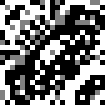

In [23]:
let
    new_frame = Array{Float64,2}(undef, number_of_rows, number_of_columns);
    for j ∈ 1:number_of_rows
        for k ∈ 1:number_of_columns
            if myframe[j,k] == 0
                new_frame[j,k] = 1.0; # buy
            elseif myframe[j,k] == 1
                new_frame[j,k] = 0.5; # hold
            elseif myframe[j,k] == 2
                new_frame[j,k] = 0.0; # sell
            end
        end
    end
    display(Gray.(new_frame[10:30,10:30]))
end

### TODO: Analyze the state dynamics of a three-color world
Fill me in

In [94]:
average_state_array = Array{Float64,2}(undef, number_of_iterations, number_of_colors)
for i ∈ 0:(number_of_iterations - 1)
    myframe = frames[i];
    for s ∈ 1:number_of_colors
        average_state_array[i+1,s] = findall(x -> x == s-1, myframe) |> length |> len -> (len/number_of_agents)
    end
end
average_state_array;

#### Visualize the evolution of the state fraction of the grid world
Fill me in

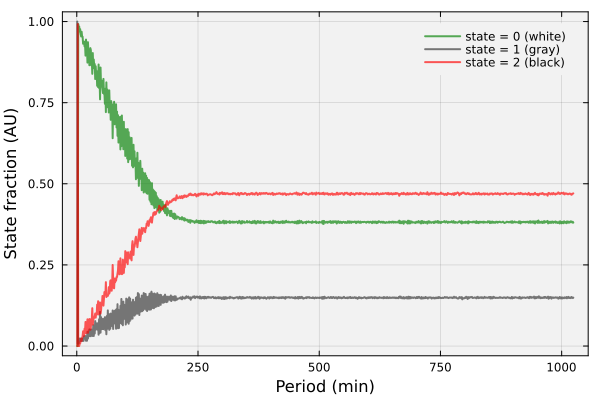

In [96]:
let
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    color_dictionary = Dict(0 =>:green,1=>:gray20,2=>:red);
    color_label_dictionary = Dict(0 => "white", 1 => "gray", 2 => "black");
    for s ∈ 1:number_of_colors
        plot!(q, average_state_array[:,s], label="state = $(s-1) ($(color_label_dictionary[s-1]))", 
            lw=2, c=color_dictionary[s-1], alpha=0.65)
    end
    current()
    xlabel!("Period (min)", fontsize=18)
    ylabel!("State fraction (AU)", fontsize=18)
end

#### Visualize the state of a particular agent in the world
Fill me in

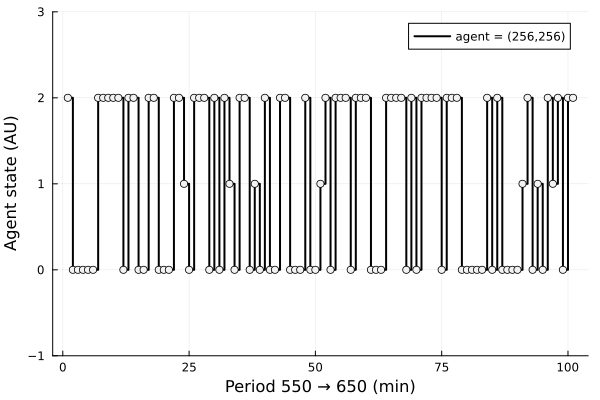

In [92]:
let
    i,j = middle,middle; # center agent
    index_array = range(turn_index_to_view-view_width,stop=turn_index_to_view+view_width,step=1)
    
    agent_dynamics_array = Array{Int64,1}(undef, number_of_iterations)
    for k ∈ 0:(number_of_iterations - 1)
        frame = frames[k];
        agent_dynamics_array[k+1] = frame[i,j];
    end
    plot(agent_dynamics_array[index_array], ylims=(-1,3), linetype=:steppost, c=:black, lw=2, label="agent = ($(i),$(j))")
    scatter!(agent_dynamics_array[index_array], label="", c=:gray95)
    xlabel!("Period $(first(index_array)) → $(last(index_array)) (min)", fontsize=18)
    ylabel!("Agent state (AU)", fontsize=18)
end

## Task 3: Learn the policy function by observing agent choices
Fill me in

### TODO: Setup in-sample state dataset
Fill me in

In [32]:
î,ĵ = middle,middle
period =  range(turn_index_to_view - view_width, stop=turn_index_to_view+view_width,step=1) |> collect;

Fill me in

In [34]:
moves_dictionary = Dict(
    1 => (-1,0), # up
    2 => (1,0),  # down
    3 => (0,-1), # left
    4 => (0,1),  # right
);

Fill me in

In [36]:
in_sample_dataset = Dict{Int64, Array{Int64,1}}();
N = length(period);
for p ∈ 1:(N - 1)  

    my_current_frame = period[p] |> t-> frames[t];
    my_next_frame = period[p+1] |> t-> frames[t];
    
    data = Array{Int64,1}(undef, radius+1)
    for k ∈ 1:radius
        Δ = moves_dictionary[k];
        i,j = î + Δ[1], ĵ + Δ[2];        
        data[k] = my_current_frame[i,j];
    end
    data[radius + 1] = my_next_frame[î,ĵ]; # reminder: the rule gives us the *next* state    
    in_sample_dataset[p] = data; 
end

In [37]:
length(in_sample_dataset)

100

#### Check: Does the in-sample dataset obey the rules?
Fill me in

In [39]:
let
    Q = policy_model.Q;
    R = policy_model.rule;
    N = length(period);
    for p ∈ 1:(N - 1)
        data = in_sample_dataset[p];
        j = Q[round(mean(data[1:radius]), digits=2)]; # index in rule
        s = R[j]; # actual *next* state s
        ŝ = data[end]; # predicted *next* state ŝ
    
        # Are the actual and predicted *next* states the same?
        @assert s == ŝ
    end
end

### TODO: Learn the agent policy
Fill me in

In [41]:
worlfram_gridworld_model = build(MyWolframGridWorldModel, (
    number_of_states = length(policy_model.rule),
    data = in_sample_dataset,
    policymap = policy_model.Q
));

Fill me in

In [43]:
learning_model = build(MyWolframRuleQLearningAgentModel, (
    states = range(1, stop=number_of_states, step=1) |> collect,
    actions = range(1, stop=number_of_colors, step=1) |> collect,
    γ = 0.95,
    α = 0.70,
    Q = zeros(number_of_states,number_of_colors),
));

Fill me in

In [45]:
test = VLQuantitativeFinancePackage.sample(learning_model, worlfram_gridworld_model, 
    maxsteps = length(in_sample_dataset) - 1);

In [46]:
Q̂ = test.Q

9×3 Matrix{Float64}:
  78.4585  56.1546  36.8576
   0.0      0.0      0.0
  87.4608   0.0     30.2644
   0.0      0.0      0.0
  80.4115  79.4664  85.7822
   0.0      0.0      0.0
  75.8952  53.5903   0.0
   0.0      0.0      0.0
 104.138   57.8581  57.1848

Fill me in

In [88]:
π̂ = Dict{Int64,Int64}()
for s ∈ 0:(number_of_states - 1)
    π̂[s] = argmax(Q̂[s+1,:]) - 1;
end
π̂

Dict{Int64, Int64} with 9 entries:
  0 => 0
  4 => 2
  5 => 0
  6 => 0
  2 => 0
  7 => 0
  8 => 0
  3 => 0
  1 => 0

In [84]:
policy_model.rule

Dict{Int64, Int64} with 9 entries:
  0 => 0
  4 => 2
  5 => 0
  6 => 2
  2 => 1
  7 => 0
  8 => 0
  3 => 0
  1 => 2

### Check: Are the estimated policy and the Wolfram rules the same?
Fill me in

In [50]:
R = policy_model.rule;
for s ∈ 0:(number_of_states - 1)
    
    true_action = R[s];      # get the true action from the rule for state s
    estimated_action = π̂[s]; # get the action we estimated for state s

    if (true_action != estimated_action)
        println("Error: for state $(s) true action is $(true_action) we estimated $(estimated_action)")
        @assert false;
    end
end

Error: for state 1 true action is 2 we estimated 0


LoadError: AssertionError: false

### What states does the subject agent see?

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

In [52]:
# for i ∈ 0:(number_of_iterations - 1)
#     frame = frames[i];
#     new_frame = Array{Float64,2}(undef, number_of_rows, number_of_columns);
#     for j ∈ 1:number_of_rows
#         for k ∈ 1:number_of_columns
#             if frame[j,k] == 0
#                 new_frame[j,k] = 1.0;
#             elseif frame[j,k] == 1
#                 new_frame[j,k] = 0.5;
#             elseif frame[j,k] == 2
#                 new_frame[j,k] = 0.0;
#             end
#         end
#     end
#     display(Gray.(new_frame))
#     IJulia.clear_output(true)
# end